In [7]:
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from download_data import get_price, get_mpd, get_fx, get_commodity
from data_analysis.explore_data import (
    calc_rolling_stat,
    merge_prob_stat,
    rename_stat_df,
    eval_large_change_prob,
    plot_change_scatter,
    prep_regression_stat,
    compare_regressions,
    compare_regression_eval
)

In [8]:
data = get_mpd()
start_date, end_date = data["idt"].min(), data["idt"].max()
print(start_date, end_date)

2006-01-12 00:00:00 2024-01-10 00:00:00


In [9]:
fx = data.loc[data["type"].isin(["fx"])]
fx.groupby("market").first()

,idt,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,name,type
market,,,,,,,,,,,,,,,
euro,2011-04-29 00:00:00,3.0,-0.003680,0.062659,-0.322283,0.407039,-0.084137,-0.001107,0.073021,-10.0,0.069296,10.0,0.039502,Euro-USD exchange rate (CME),fx
pound,2011-04-29 00:00:00,3.0,-0.002033,0.048537,-0.326350,0.713841,-0.062991,-0.000362,0.056491,-10.0,0.033302,10.0,0.014766,Pound-USD exchange rate (CME),fx
yen,2011-04-29 00:00:00,3.0,-0.003274,0.059893,0.213295,0.747921,-0.075532,-0.005217,0.071314,-10.0,0.049025,10.0,0.049149,Yen-USD exchange rate (CME),fx


In [10]:
equity = data.loc[data["type"].isin(["equity", "equity_idx"])]
equity.groupby("market").first()

,idt,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,name,type
market,,,,,,,,,,,,,,,
bac,2010-01-15 00:00:00,3.0,-0.025140,0.182100,-0.381730,0.851920,-0.253890,-0.016340,0.192720,-20.0,0.148980,20.0,0.093070,Bank of America Corporation,equity
citi,2010-01-15 00:00:00,3.0,-0.027030,0.216670,-0.126270,1.298230,-0.289140,-0.022310,0.226320,-20.0,0.182470,20.0,0.123160,"Citigroup, Inc.",equity
iyr,2010-10-29 00:00:00,3.0,-0.015380,0.136965,-0.948440,1.454774,-0.196561,0.005729,0.135344,-20.0,0.097426,20.0,0.022713,iShares real estate index,equity_idx
sp12m,2007-01-12 00:00:00,12.0,0.034318,0.132616,-1.055814,1.657518,-0.142450,0.057748,0.176416,-20.0,0.061515,20.0,0.056906,"S&P 500, 12-months-out",equity_idx
sp6m,2007-01-12 00:00:00,6.0,0.018803,0.086435,-1.079705,1.837194,-0.095498,0.033820,0.111149,-20.0,0.024242,20.0,0.001915,"S&P 500, 6-months-out",equity_idx


Manually translate name -> stock ticker. SPX is not a tradeable asset, therefore using SPY ETF as approximation.

Also, we can't fetch BAC data with others, hence do it separately.

In [11]:
fx = get_fx(tickers=["GBP", "EUR", "JPY"],
            start_date=start_date,
            end_date=end_date,
            use_cache=True)

In [12]:
close = get_price(tickers=["BAC", "C", "IYR", "SPY"], 
                  start_date=start_date, 
                  end_date=end_date, 
                  use_cache=True)
commodity = get_commodity(use_cache=True, 
                          start_date=start_date, 
                          end_date=end_date,)

close = pd.concat([fx, close, commodity], axis=1)
close.head()

,EUR,GBP,JPY,BAC,C,IYR,SPY,silver,corn1,corn2,soybean,gold,wheat
2006-01-12,0.829958,0.567039,113.974697,31.370887,335.512052,35.586933,91.051694,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-13,0.825866,0.564469,114.457586,31.370887,334.759323,35.013371,90.966856,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-14,0.827567,0.564547,114.464902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-15,0.827567,0.564547,114.464902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-16,0.825142,0.565478,114.801784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As mentioned in the methodology paper, all probability are 6-month probability.

In [13]:
stat = calc_rolling_stat(close, n=10)
market_list = ["bac", "citi", "iyr", "sp6m", "sp12m", "euro", "pound", "yen"] + ['silver','corn', 'soybns','gold','wheat']
ticker_list = ["BAC", "C", "IYR", "SPY", "SPY", "GBP", "EUR", "JPY"] + ['silver','corn1', 'soybean','gold','wheat']
stat_rename = rename_stat_df(stat, dict(zip(market_list, ticker_list)))
df = merge_prob_stat(stat_rename, data)
df.head()

maturity_target       mu       sd     skew     kurt  \
market idt                                                               
bac    2010-01-15              3.0 -0.02514  0.18210 -0.38173  0.85192   
       2010-01-29              3.0 -0.02194  0.21265 -0.79513  1.61552   
       2010-02-12              3.0 -0.01699  0.21625 -0.86181  1.83248   
       2010-02-26              3.0 -0.00965  0.17893 -0.70108  1.40641   
       2010-03-15              3.0  0.00006  0.17357 -0.71889  1.63480   

                       p10      p50      p90  lg_change_decr    prDec  \
market idt                                                              
bac    2010-01-15 -0.25389 -0.01634  0.19272           -20.0  0.14898   
       2010-01-29 -0.28826  0.00001  0.21786           -20.0  0.16750   
       2010-02-12 -0.28670  0.00720  0.22358           -20.0  0.16404   
       2010-02-26 -0.23570  0.00776  0.19373           -20.0  0.12882   
       2010-03-15 -0.21657  0.01649  0.19608           -20.0  0.11325   

                   lg_change_incr    prInc                         name  \
market idt                                                                
bac    2010-01-15            20.0  0.09307  Bank of America Corporation   
       2010-01-29            20.0  0.12009  Bank of America Corporation   
       2010-02-12            20.0  0.12713  Bank of America Corporation   
       2010-02-26            20.0  0.09233  Bank of America Corporation   
       2010-03-15            20.0  0.09545  Bank of America Corporation   

                     type       ret       vol   ret_max   ret_min  
market idt                                                         
bac    2010-01-15  equity -0.081992  0.603384  0.014046 -0.087347  
       2010-01-29  equity -0.047210  0.372908  0.027292 -0.047210  
       2010-02-12  equity  0.114934  0.315681  0.114934  0.000000  
       2010-02-26  equity  0.005401  0.139997  0.005401 -0.016950  
       2010-03-15  equity  0.049824  0.254600  0.049824 -0.012408

## 3. Time-Series Regression (2-week Return)

We ran time-series regression, i.e. SARIMA, GARCH, MarkovRegression with and without probability data and compare the model accuracy.


#### 3.1. Preparation
This part, we made 3 plots:
- ACF / PACF: to evaluate p, q for ARIMA / GARCH model. 
- Seasonal Decompose: to evaluate seasonal trend in a model.
- FFT Power Spectrum: to find most seasonal period.

Findings:
1. ACF shows significance for period <= 6 * 2W (p=6) and PACF shows significant <= 2 * 2W (q=2). However, one problem here is we are using bi-weekly interval data of 6 month returns. Therefore, time-series modeling would constantly peeking into future data.
2.  FFT shows different seasonality for all different series.

/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:250: RuntimeWarning: divide by zero encountered in divide
  ax_f[n].stem(1 / freq, power_spectrum)
/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:250: RuntimeWarning: divide by zero encountered in divide
  ax_f[n].stem(1 / freq, power_spectrum)
/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:250: RuntimeWarning: divide by zero encountered in divide
  ax_f[n].stem(1 / freq, power_spectrum)
/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:250: RuntimeWarning: divide by zero encountered in divide
  ax_f[n].stem(1 / freq, power_spectrum)
/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:250: RuntimeWarning: divide by zero encountered in divide
  ax_f[n].stem(1 / freq, power_spectrum)
/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:250: RuntimeWarning: divide by zero encountered in divi

{'bac': 52.285714285714285,
 'citi': 16.636363636363637,
 'corn': 5.818181818181818,
 'euro': 6.466019417475728,
 'gold': 5.433962264150944,
 'iyr': 115.33333333333334,
 'pound': 8.430379746835444,
 'silver': 9.600000000000001,
 'soybns': 4.085106382978724,
 'sp12m': 18.163265306122447,
 'sp6m': 18.163265306122447,
 'wheat': 14.048780487804878,
 'yen': 6.054545454545455}

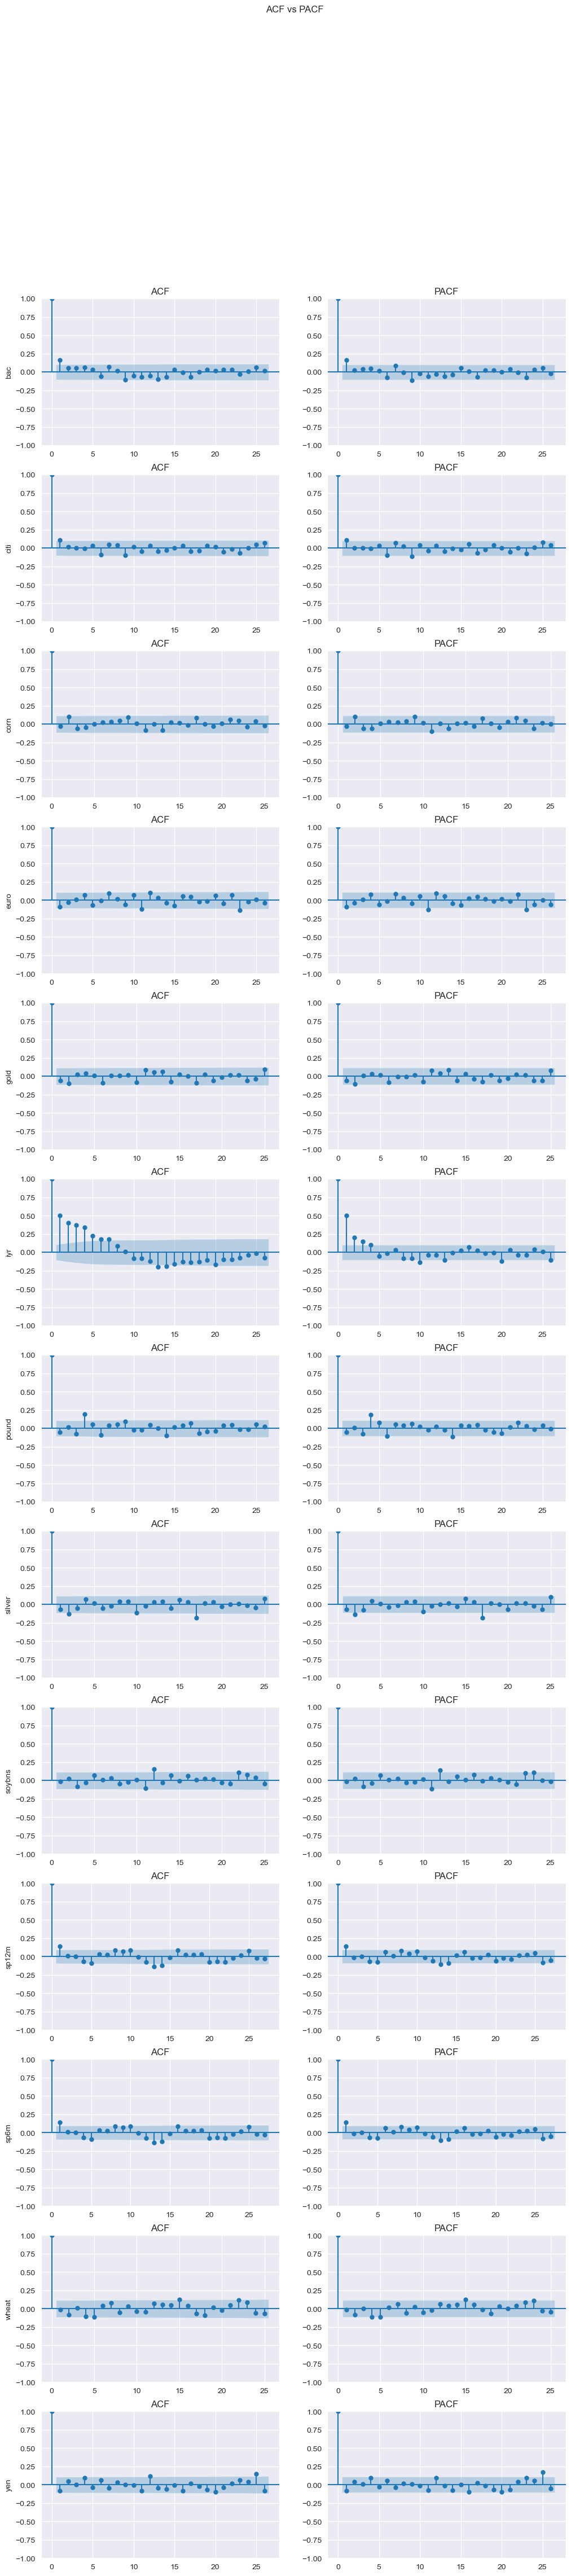

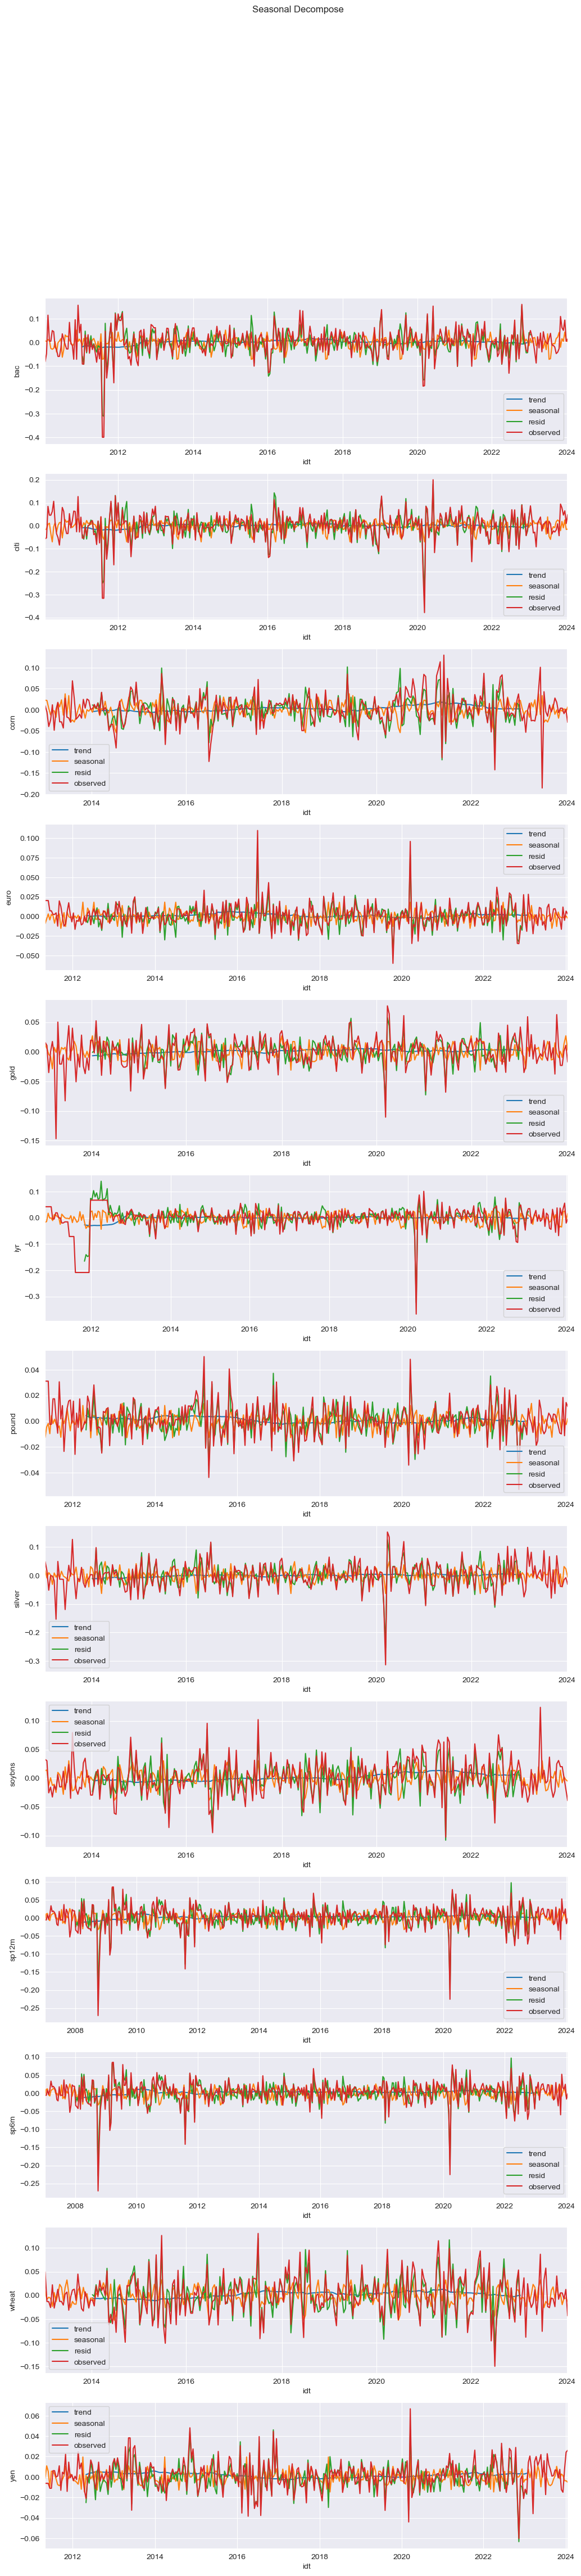

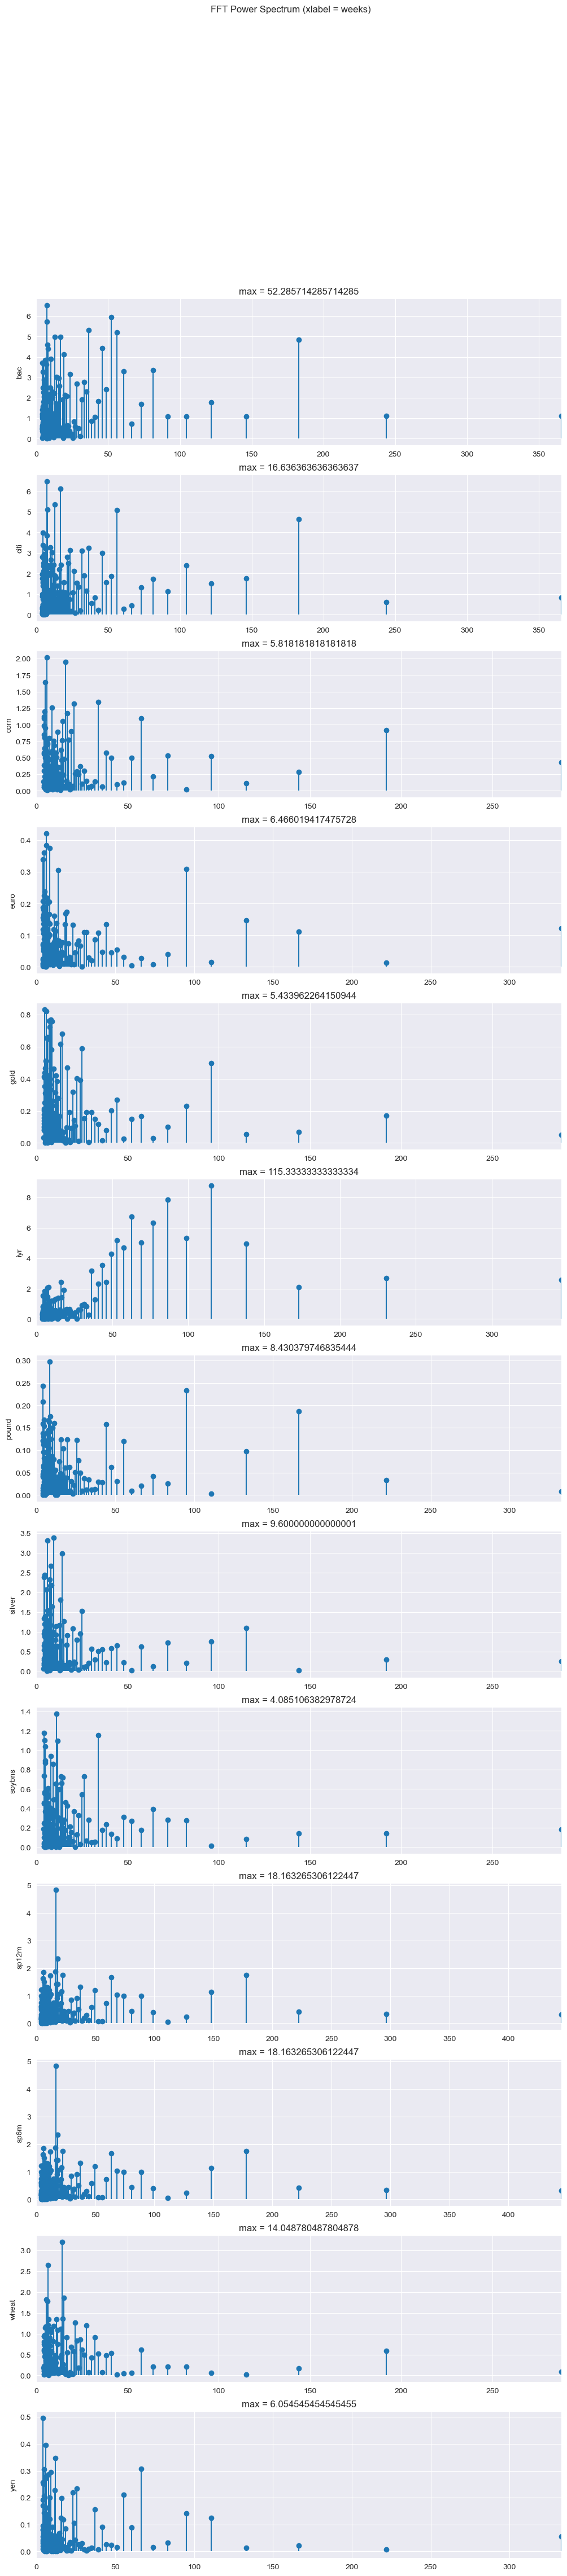

In [14]:
prep_regression_stat(df)

#### 3.2. Compare Regression 
We compare results of with/without probability as exogenous data for follow 4 regression
1. SARIMA
2. GARCH
3. Markov (Change Mean)
4. Markov (Change Volatility)

With a naive model (p=1, q=1), we see with probability tends to outperform by BIC for equity on all models, except for Garch-iyr.

For FX, results are more mixed.
- ARIMA: only yen outperforms with probability
- GARCH: everything outperform
- Markov Mean / Markov Volatility: only pound outperforms. 

In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
import statsmodels.api as sm
from functools import partial

arima = compare_regressions(df, partial(SARIMAX, order=(1, 0, 1)))
garch = compare_regressions(
    df, partial(arch_model, p=1, q=1, mean='ARX', vol='GARCH'),
    model_ret_name="y", model_prob_name="x",
)
markov = compare_regressions(df, partial(sm.tsa.MarkovRegression, k_regimes=3))
markov_vol = compare_regressions(df, partial(sm.tsa.MarkovRegression, k_regimes=3,
                                             switching_variance=True))

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.38932D+00    |proj g|=  1.04743D-01

At iterate    5    f= -1.38933D+00    |proj g|=  3.30101D-02

At iterate   10    f= -1.38934D+00    |proj g|=  2.46062D-03

At iterate   15    f= -1.38934D+00    |proj g|=  2.51945D-02

At iterate   20    f= -1.38940D+00    |proj g|=  6.30272D-03

At iterate   25    f= -1.38943D+00    |proj g|=  3.88198D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     42      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     34      1     0     0   6.599D-04  -1.853D+00
  F =  -1.8532809864943047     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.74531D+00    |proj g|=  4.23615D-01

At iterate    5    f= -2.74534D+00    |proj g|=  4.40815D-01

At iterate   10    f= -2.74544D+00    |proj g|=  2.98928D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f= -2.20639D+00    |proj g|=  5.77960D-02

At iterate   25    f= -2.20649D+00    |proj g|=  2.62764D-01

At iterate   30    f= -2.20651D+00    |proj g|=  2.78376D-03

At iterate   35    f= -2.20652D+00    |proj g|=  1.90828D-02

At iterate   40    f= -2.20660D+00    |proj g|=  3.14348D-01

At iterate   45    f= -2.20700D+00    |proj g|=  8.73708D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     55      1     0     0   4.152D-05  -2.207D+00
  F =  -2.2070437511145857     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f= -1.73346D+00    |proj g|=  1.09013D-01

At iterate   35    f= -1.73351D+00    |proj g|=  5.15642D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     47      1     0     0   8.714D-04  -1.734D+00
  F =  -1.7335156959082114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.90719D+00    |proj g|=  3.28038D+00

At iterate    5    f= -2.90764D+00    |proj g|=  1.29188D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.62747D+00    |proj g|=  4.74724D-02

At iterate    5    f= -1.62757D+00    |proj g|=  1.19717D-01

At iterate   10    f= -1.62858D+00    |proj g|=  1.70967D-01

At iterate   15    f= -1.62863D+00    |proj g|=  2.83718D-02

At iterate   20    f= -1.62885D+00    |proj g|=  2.73875D-03

At iterate   25    f= -1.62885D+00    |proj g|=  3.04025D-02

At iterate   30    f= -1.62906D+00    |proj g|=  8.18117D-02

At iterate   35    f= -1.62994D+00    |proj g|=  1.57443D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/claircui/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/claircui/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
/Users/claircui/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/claircui/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  wa

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.99853D+00    |proj g|=  2.72298D-01

At iterate    5    f= -1.99855D+00    |proj g|=  1.01615D-01

At iterate   10    f= -1.99857D+00    |proj g|=  7.98464D-02

At iterate   15    f= -1.99862D+00    |proj g|=  2.14137D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   1.038D-03  -1.999D+00
  F =  -1.9986364968138484     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.75243D+00    |proj g|=  1.76716D-01

At iterate    5    f= -1.75245D+00    |proj g|=  7.51520D-02

At iterate   10    f= -1.75247D+00    |proj g|=  1.14276D-03

At iterate   15    f= -1.75247D+00    |proj g|=  1.07245D-02

At iterate   20    f= -1.75251D+00    |proj g|=  1.13081D-02

At iterate   25    f= -1.75253D+00    |proj g|=  1.35272D-02

At iterate   30    f= -1.75548D+00    |proj g|=  6.76601D-01

At iterate   35    f= -1.75635D+00    |proj g|=  6.45465D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.
/Users/claircui/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/claircui/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003744. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(



At iterate   25    f= -2.80716D+00    |proj g|=  2.08334D-01

At iterate   30    f= -2.80718D+00    |proj g|=  2.46925D-02

At iterate   35    f= -2.80718D+00    |proj g|=  3.46882D-02

At iterate   40    f= -2.80786D+00    |proj g|=  2.66976D-01

At iterate   45    f= -2.80989D+00    |proj g|=  5.85529D-02

At iterate   50    f= -2.80989D+00    |proj g|=  9.79246D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     72      1     0     0   9.792D-04  -2.810D+00
  F =  -2.8098939656033091     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Iteration:      1,   Func. Count:      6,   Neg. LL

/Users/claircui/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003734. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/claircui/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.003487. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/claircui/anaconda3/lib/python3.11/site-packages/a

Iteration:     10,   Func. Count:    111,   Neg. LLF: 26405.56037553947
Iteration:     11,   Func. Count:    120,   Neg. LLF: -985.1163486121225
Optimization terminated successfully    (Exit mode 0)
            Current function value: -985.1163482651305
            Iterations: 15
            Function evaluations: 120
            Gradient evaluations: 11
Iteration:      1,   Func. Count:      8,   Neg. LLF: 615971054325.2427
Iteration:      2,   Func. Count:     22,   Neg. LLF: 6012979637.832567
Optimization terminated successfully    (Exit mode 0)
            Current function value: -988.5847925194328
            Iterations: 2
            Function evaluations: 30
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      6,   Neg. LLF: 1048054.5550757723
Iteration:      2,   Func. Count:     16,   Neg. LLF: -264.0469967288652
Iteration:      3,   Func. Count:     25,   Neg. LLF: -465.1178101502425
Iteration:      4,   Func. Count:     31,   Neg. LLF: -476.8539073588428


/Users/claircui/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/claircui/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/claircui/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/claircui/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/claircui/anaconda3/lib/python3.11/site-packag

In [16]:
compare_regression_eval(arima, "bic").loc[market_list]

,with,without,diff
bac,-987.586795,-999.354069,11.767273
citi,-1007.712515,-1019.491183,11.778668
iyr,-1170.360668,-1180.907062,10.546394
sp6m,-1749.494501,-1759.738207,10.243706
sp12m,-1748.296111,-1759.738207,11.442096
euro,-1804.513811,-1811.037270,6.523459
pound,-1918.285524,-1920.304591,2.019067
yen,-1842.348669,-1845.395181,3.046512
silver,-910.532553,-921.682271,11.149718
corn,-1039.175046,-1049.440846,10.265801


In [17]:
compare_regression_eval(garch, "bic").loc[market_list]

,with,without,diff
bac,-1031.383366,-1042.393549,11.010183
citi,-1078.708470,-1086.778360,8.069890
iyr,-1247.552341,-1343.710722,96.158382
sp6m,-1809.939125,-1816.073477,6.134352
sp12m,-1810.222706,-1816.073477,5.850771
euro,-1804.278725,-1812.283288,8.004564
pound,-1942.320730,-1947.000127,4.679396
yen,-1876.587670,-1884.690213,8.102543
silver,-926.769399,-932.120481,5.351082
corn,-1081.716659,-1092.985401,11.268742


In [18]:
compare_regression_eval(markov, "bic").loc[market_list]

,with,without,diff
bac,-1054.274594,-1033.243071,-21.031522
citi,-1091.122602,-973.412627,-117.709976
iyr,-1368.462062,-1357.117957,-11.344105
sp6m,-1898.349726,-1728.794440,-169.555286
sp12m,-1914.710967,-1728.794440,-185.916527
euro,-1839.099612,-1860.716245,21.616634
pound,-1896.939583,-1880.419031,-16.520552
yen,-1834.077908,-1846.854565,12.776657
silver,-898.834713,-922.054501,23.219788
corn,-1060.895074,-1033.447254,-27.447820


In [19]:
compare_regression_eval(markov_vol, "bic").loc[market_list]

,with,without,diff
bac,-1044.456818,-1147.351350,102.894532
citi,-1073.699924,-1087.365895,13.665971
iyr,-1337.050831,-1342.742072,5.691242
sp6m,-1920.277687,-1921.514824,1.237137
sp12m,-1903.889228,-1921.514824,17.625596
euro,-1840.078470,-1844.986349,4.907879
pound,-1894.039305,-1918.237432,24.198127
yen,-1845.012130,-1861.726965,16.714835
silver,-898.674479,-920.039296,21.364817
corn,-1036.448752,-1068.534372,32.085620
